## Métricas de evaluación y puntuaciones

Hasta ahora, hemos evaluado el rendimiento de una  clasificación usando la precisión (la fracción de muestras correctamente clasificadas) y el rendimiento de la regresión usando $R^2$. Sin embargo, estas son solo dos de las muchas formas posibles de resumir qué tan bien se desempeña un modelo supervisado en un conjunto de datos determinado. En la práctica, estas medidas de evaluación pueden no ser apropiadas para su aplicación  y es importante elegir la métrica correcta al seleccionar entre modelos y ajustar los parámetros.

Al seleccionar una métrica, siempre debe tener en mente el objetivo final de la aplicación del machine learning. En la práctica, generalmente nos interesa no solo hacer predicciones precisas, sino también usar estas predicciones como parte de un proceso de toma de decisiones más amplio. Antes de elegir una métrica de machine learning, se debe pensar en el objetivo de alto nivel de la aplicación, a menudo denominado métrica de negocio. Las consecuencias de elegir un algoritmo particular para una aplicación de machine learning  es llamado impacto de negocios.

En este cuaderno, primero discutiremos las métricas para el caso especial de clasificación binaria, luego daremos vuelta a la clasificación multiclase y finalmente a la regresión.

## Métricas de clasificación binaria 

La clasificación binaria es posiblemente la aplicación más común y conceptualmente simple del machine learning automático en la práctica. Sin embargo, todavía hay una serie de advertencias al evaluar incluso en esta simple tarea. Antes de sumergirnos en métricas alternativas, echemos un vistazo a las formas en que la medición de la  precisión  puede ser engañosa. Se debe recordar que para una clasificación binaria, se habla de una clase positiva y una clase negativo,  con el entendimiento de que la clase positiva es la que estamos buscando.

### Tipos de errores

A menudo, la precisión no es una buena medida del rendimiento predictivo, ya que la cantidad de errores que cometemos no contiene toda la información que nos interesa. Imagina una aplicación para detectar la detección temprana del cáncer mediante una prueba automatizada. Si la prueba es negativa, se asumirá que el paciente está sano, mientras que si la prueba es positiva, el paciente se someterá a exámenes adicionales. Aquí, llamaríamos a una prueba positiva (una indicación de cáncer) la clase positiva y una prueba negativa la clase negativa. No podemos suponer que nuestro modelo siempre funcionará perfectamente y cometerá errores. Para cualquier aplicación, debemos preguntarnos cuáles podrían ser las consecuencias de estos errores en el mundo real.

Un posible error es que un paciente sano será clasificado como positivo, lo que lleva a pruebas adicionales. Esto conlleva algunos costos y un inconveniente para el paciente (y posiblemente algún problema mental). Una predicción positiva incorrecta se llama un `falso positivo`. El otro posible error es que un paciente enfermo se clasificará como negativo y no recibirá más pruebas y tratamiento. El cáncer no diagnosticado podría causar problemas graves de salud e incluso podría ser fatal. Un error de este tipo, una predicción negativa incorrecta, se denomina `falso negativo`. En las estadísticas, un falso positivo también se conoce como `error tipo I` y un falso negativo como `error tipo II`. Nos apegaremos a `falso negativo` y `falso positivo`, ya que son más explícitos y fáciles de recordar.

En el ejemplo del diagnóstico de cáncer, queremos evitar `falsos negativos` tanto como sea posible, mientras que los `falsos positivos` se pueden ver como una molestia menor.

### Conjuntos de datos no balanceados

Los tipos de errores juegan un papel importante cuando una de dos clases es mucho más frecuente que la otra. Esto es muy común en la práctica; un buen ejemplo es la predicción de `clics`, donde cada punto de datos representa una "impresión", un elemento que se mostró a un usuario. Este elemento podría ser un anuncio, una historia relacionada o una persona relacionada para seguir en un sitio de redes sociales. 

El objetivo es predecir si, si se muestra un elemento en particular, un usuario hará clic en él (lo que indica que están interesados). La mayoría de las cosas que los usuarios muestran en Internet (en particular, los anuncios) no generarán un clic. Es posible que deba mostrarle a un usuario 100 anuncios o artículos antes de que se encuentre  algo lo suficientemente interesante como para hacer clic. Esto da como resultado un conjunto de datos donde para cada 99 puntos de datos "sin clic", hay 1 punto de datos "hecho clic"; en otras palabras, el 99% de las muestras pertenecen a la clase "sin clic".

Los conjuntos de datos en los que una clase es mucho más frecuente que la otra a menudo se denominan conjuntos de datos no balanceados o conjuntos de datos con clases no balanceados. En realidad, los datos no balanceados son la norma y es raro que los eventos de interés tengan una frecuencia igual o incluso similar en los datos.

Ahora supongamos que crea un clasificador que es 99% preciso en la tarea de predicción de clics. ¿Qué te dice eso? El 99% de precisión suena impresionante, pero esto no tiene en cuenta las clases no balaceadas. Puede lograr el 99% de precisión sin crear un modelo de machine learning, al predecir siempre "sin clic". Por otro lado, incluso con datos no balanceados, un modelo con un 99% de precisión podría ser bastante bueno. Sin embargo, la precisión no nos permite distinguir el modelo constante de "no hacer clic" de un modelo potencialmente bueno.

#### Ejemplo

Crearemos un conjunto de datos desequilibrado 9: 1 del conjunto de datos `digits`, al clasificar el dígito 9 frente a las otras nueve clases:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_digits

digitos = load_digits()
y = digitos.target == 9
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    digitos.data, y, random_state=0)

Podemos usar el `DummyClassifier` para predecir siempre la clase mayoritaria (aquí "no nueve") para ver qué tan desinformativa puede ser la precisión:

In [2]:
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_entrenamiento, y_entrenamiento)
pred_mas_frecuente = clf_dummy.predict(X_prueba)
print("Etiquetas predecidas unicas: {}".format(np.unique(pred_mas_frecuente)))
print("Puntuacion del conjunto de pruebas: {:.2f}".format(clf_dummy.score(X_prueba, y_prueba)))

Etiquetas predecidas unicas: [False]
Puntuacion del conjunto de pruebas: 0.90


Obtuvimos cerca del 90% de precisión sin aprender nada. Esto puede parecer sorprendente, pero piénselo un momento. Imagine que alguien le dice que su modelo es 90% preciso. Podrías pensar que hicieron un muy buen trabajo. ¡Pero dependiendo del problema, eso podría ser posible simplemente prediciendo una clase! Comparemos esto con el uso de un clasificador real:

In [3]:
from sklearn.tree import DecisionTreeClassifier
clf_arbol = DecisionTreeClassifier(max_depth=2).fit(X_entrenamiento, y_entrenamiento)
pred_arbol = clf_arbol.predict(X_prueba)
print("Test score: {:.2f}".format(clf_arbol.score(X_prueba, y_prueba)))

Test score: 0.92


Según el valor de la  precisión obtenida, el `DecisionTreeClassifier`, es ligeramente mejor que el predictor constante. Esto podría indicar que algo está mal con la forma en que usamos el clasificador  `DecisionTreeClassifier`, o que la precisión de hecho no es una buena medida aquí.

Para propósitos de comparación, evaluemos dos clasificadores más, `LogisticRegression` y el predeterminado `DummyClassifier`, que hace predicciones aleatorias pero produce clases con las mismas proporciones que en el conjunto de entrenamiento:

In [4]:
from sklearn.linear_model import LogisticRegression
clf_dummy = DummyClassifier().fit(X_entrenamiento, y_entrenamiento)
pred_dummy = clf_dummy.predict(X_prueba)
print("Puntuacion dummy : {:.2f}".format(clf_dummy.score(X_prueba, y_prueba)))
logreg = LogisticRegression(C=0.1).fit(X_entrenamiento, y_entrenamiento)
pred_logreg = logreg.predict(X_prueba)
print("Puntuacion logreg : {:.2f}".format(logreg.score(X_prueba, y_prueba)))

Puntuacion dummy : 0.83
Puntuacion logreg : 0.98


El clasificador dummy que produce resultados aleatorios es claramente el peor del lote (de acuerdo con la precisión), mientras que LogisticRegression produce muy buenos resultados. Sin embargo, incluso el clasificador aleatorio produce más del 80% de precisión. Esto hace que sea muy difícil juzgar cuál de estos resultados es realmente útil. El problema aquí es que la precisión es una medida inadecuada para cuantificar el rendimiento predictivo en este entorno no balanceado.

### Matriz de confusión

Una de las formas más completas de representar el resultado de evaluar la clasificación binaria es usar matrices de confusión. Examinemos las predicciones de LogisticRegression de la sección anterior usando la función `confusion_matrix`. Ya almacenamos las predicciones en el conjunto de prueba en `pred_logreg`:

In [5]:
from sklearn.metrics import confusion_matrix
matriz_confusion = confusion_matrix(y_prueba, pred_logreg)
print("Matriz de confusion:\n{}".format(matriz_confusion))

Matriz de confusion:
[[401   2]
 [  8  39]]


La salida de `confusion_matrix` es una matriz de dos por dos, donde las filas corresponden a las clases verdaderas y las columnas corresponden a las clases predichas. Cada entrada cuenta la frecuencia con que una muestra  pertenece a la clase correspondiente a la fila (aquí, "no nueve" y "nueve") se clasificó como la clase correspondiente a la columna. La siguiente gráfica ilustra este significado:

In [6]:
% run matriz_confusion.py

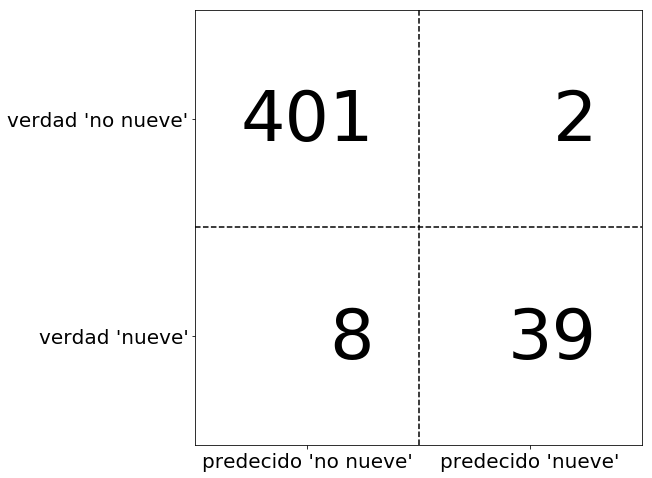

In [7]:
dibujo_ilustracion_matriz_confusion()

Las entradas en la diagonal principal de la matriz de confusión corresponden a las clasificaciones correctas, mientras que otras entradas nos dicen cuántas muestras de una clase se clasificaron erróneamente como otra clase.

Si declaramos "un nueve" la clase positiva, podemos relacionar las entradas de la matriz de confusión con los términos falso positivo y falso negativo que presentamos anteriormente. Para completar la imagen, llamamos muestras correctamente clasificadas pertenecientes a la clase positiva, `verdaderos positivos` y muestras correctamente clasificadas pertenecientes a la clase negativa, `verdaderos negativos`. Estos términos generalmente se abrevian `FP`, `FN`, `TP` y `TN` y conducen a la siguiente interpretación para la matriz de confusión:

In [8]:
% run matriz_confusion_binaria.py

<Figure size 432x288 with 0 Axes>

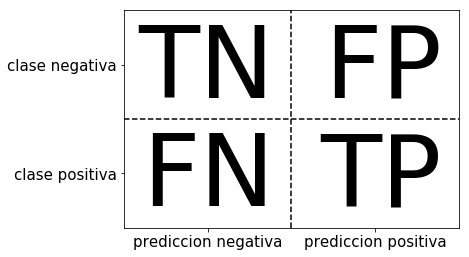

In [9]:
dibuja_matriz_confusion_binaria()

Ahora usemos la matriz de confusión para comparar los modelos que ajustamos anteriormente (los dos modelos dummy,  árboles de decisión y la regresión logística):

In [10]:
print("Clases mas frecuentes:")
print(confusion_matrix(y_prueba, pred_mas_frecuente))
print("\nModelo dummy:")
print(confusion_matrix(y_prueba, pred_dummy))
print("\nArboles de decision:")
print(confusion_matrix(y_prueba, pred_arbol))
print("\nRegresion logistica")
print(confusion_matrix(y_prueba, pred_logreg))

Clases mas frecuentes:
[[403   0]
 [ 47   0]]

Modelo dummy:
[[359  44]
 [ 43   4]]

Arboles de decision:
[[390  13]
 [ 24  23]]

Regresion logistica
[[401   2]
 [  8  39]]


Al observar la matriz de confusión, notamos que algo anda mal con `pred_mas_frecuente`, porque siempre predice la misma clase. `pred_dummy`, por otro lado, tiene un número muy pequeño de verdaderos positivos (7), particularmente en comparación con el número de falsos negativos y falsos positivos: ¡hay muchos más falsos positivos que verdaderos positivos! Las predicciones hechas por el árbol de decisiones tienen mucho más sentido que las predicciones dummies, aunque la precisión era casi la misma. Podemos ver también  que la regresión logística es mejor que `pred_arbol` en todos los aspectos: tiene más verdaderos positivos y verdaderos negativos, mientras que tiene menos falsos positivos y falsos negativos. De esta comparación, solo  los árboles  de decisión y la regresión logística dan resultados razonables y que la regresión logística funciona mejor que el árbol de decisión en todas las cuentas.

Sin embargo, inspeccionar la matriz de confusión completa es un poco engorroso, y si bien obtuvimos una gran cantidad de información al observar todos los aspectos de la matriz, el proceso fue muy manual y cualitativo. Hay varias formas de resumir la información en la matriz de confusión, que discutiremos a continuación:



 $exactitud = \frac{TP +TN}{TP +TN +FP +FN}$
    
En otras palabras, la exactitud es el número de predicciones correctas (TP y TN) dividido por el número de todas las muestras (todas las entradas de la matriz de confusión se suman).

Hay muchas otras maneras de resumir la matriz de confusión, siendo las más comunes la precisión y la exhaustividad. La precisión mide cuántas de las muestras predichas como positivas son realmente positivas:

$precision = \frac{TP}{TP + FP}$

La precisión se usa como una métrica de rendimiento cuando el objetivo es limitar el número de falsos positivos.

 La exahustividad, mide cuántas de las muestras positivas son capturadas por las predicciones positivas:
 
 $exhaustividad = \frac{TP}{TP +FN}$
 
Se utiliza como métrica de rendimiento cuando necesitamos identificar todas las muestras positivas; es decir, cuando es importante evitar falsos negativos.

Existe una compensación  entre optimizar la exhaustividad y optimizar la precisión. Se puede obtener trivialmente una exhaustividad perfecta si predice que todas las muestras que pertenecen a la clase positiva; no hay falsos negativos ni verdaderos negativos. Sin embargo, predecir todas las muestras como positivas dará como resultado muchos falsos positivos y por lo tanto, la precisión será muy baja.

Por otro lado, si se  encuentra un modelo que predice solo el punto de datos único que está más seguro como positivo y el resto como negativo, entonces la precisión será perfecta (suponiendo que este punto de datos sea de hecho positivo), con una mala exhaustividad.

Aunque la precisión y la exhaustividad son medidas muy importantes, utilizar solo a uno de ellos no le proporcionará una imagen completa. Una forma de resumirlos es con el  `f-score` o `f-measure`, que es la media armónica de la precisión y la exhaustividad:

$F =  2 \cdot \frac{\text{precision}\cdot \text{exhaustividad}}{\text{precision} + \text{exhaustividad}}$

Como esta medida tiene en cuenta la precisión y la exhaustividad, puede ser una mejor medida que la precisión en conjuntos de datos de clasificación binaria desbalanceados. 

In [11]:
from sklearn.metrics import f1_score
print("Puntuacion f1 mas frecuente: {:.2f}".format(f1_score(y_prueba, pred_mas_frecuente)))
print("Puntuacion f1 de un clasificador dummy: {:.2f}".format(f1_score(y_prueba, pred_dummy)))
print("Puntuacion f1 de un arbol de decision : {:.2f}".format(f1_score(y_prueba, pred_arbol)))
print("Puntuacion f1 para la regresion logistica : {:.2f}".format(f1_score(y_prueba, pred_logreg)))

Puntuacion f1 mas frecuente: 0.00
Puntuacion f1 de un clasificador dummy: 0.08
Puntuacion f1 de un arbol de decision : 0.55
Puntuacion f1 para la regresion logistica : 0.89


Podemos notar dos cosas aquí. Primero, obtenemos un mensaje de error para `pred_mas_frecuente`, ya que no hubo predicciones de la clase positiva (lo que hace que el denominador en `f-score` sea cero). Además, podemos ver una distinción bastante fuerte entre `pred_summy` y `pred_arbol`, que no estaba clara cuando se analiza solo precisión.

Usar `f-score` para la evaluación de modelos, se resume en un número. Sin embargo, `f-score` parece capturar nuestra intuición de lo que hace que un buen modelo sea mucho mejor que la precisión. Una desventaja del `f-score`, sin embargo, es que es más difícil de interpretar y explicar que la precisión.

Si queremos un resumen más completo de precisión, exhaustividad y f-score, podemos usar la función `classification_report` para calcular los tres valores  a la vez e imprimirlos en un formato agradable:

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_prueba, pred_mas_frecuente, target_names=["no nueve", "nueve"]))

             precision    recall  f1-score   support

   no nueve       0.90      1.00      0.94       403
      nueve       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



La última columna proporciona el `support` de cada clase, lo que  significa el número de muestras en cada clase de acuerdo con la observaciones empíricas.

La última fila  muestra un promedio ponderado (por el número de muestras en la clase) de los números para cada clase. Aquí hay dos reportes más, uno para el clasificador dummy y el otro para la regresión logística:

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_prueba, pred_dummy, target_names=["no nueve", "nueve"]))

             precision    recall  f1-score   support

   no nueve       0.89      0.89      0.89       403
      nueve       0.08      0.09      0.08        47

avg / total       0.81      0.81      0.81       450



In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_prueba, pred_logreg, target_names=["no nueve", "nueve"]))

             precision    recall  f1-score   support

   no nueve       0.98      1.00      0.99       403
      nueve       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



Como se puede observar al mirar los reportes, las diferencias entre el modelo dummy  y un modelo muy bueno ya no son tan claros. Escoger qué clase es declarada como la clase positiva tiene un gran impacto en las métricas.

### Teniendo en cuenta la incertidumbre

La matriz de confusión y `classification_report`,  proporcionan un análisis muy detallado de un conjunto particular de predicciones. Sin embargo, las predicciones mismas ya arrojaron mucha información que está contenida en el modelo. La mayoría de los clasificadores proporcionan `funcion_decision` o un método de `predict_proba` para evaluar los grados de certeza sobre las predicciones. Hacer predicciones puede verse como el umbral de la salida de `funcion_decision` o `predict_proba` en un cierto punto fijo; en la clasificación binaria usamos 0 para la función de decisión y 0.5 para `predict_proba`.

#### Ejemplo

El siguiente es un ejemplo de una tarea de clasificación binaria desbalanceada, con 400 puntos en la clase negativa clasificados contra 50 puntos en la clase positiva. Los datos de entrenamiento se muestran a la izquierda de la siguiente figura. Formamos un modelo SVM de kernel con estos datos y los gráficos a la derecha de los datos de entrenamiento ilustran los valores de la función de decisión como un mapa de calor:

In [15]:
% run datos_desbalanceados.py

<Figure size 432x288 with 0 Axes>

In [16]:
%run puntuacion_2d.py

In [17]:
% run dispersion_discreta.py

In [18]:
% run separador_2d.py

In [19]:
% run umbral_decision.py

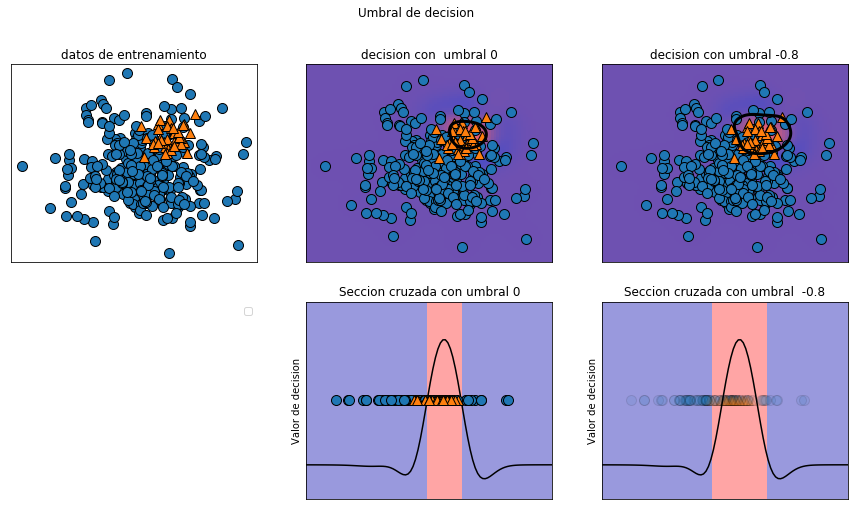

In [20]:
dibuja_umbral_decision()

Podemos usar la función `classification_report` para evaluar la precisión y exhaustividad para ambas clases:

In [21]:
X, y = hacer_blobs(n_muestras=(400, 50), centros=2, cluster_std=[7.0, 2],
                      random_state=22)
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_entrenamiento, y_entrenamiento)
print(classification_report(y_prueba, svc.predict(X_prueba)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



Para la clase 1, obtenemos un `recall` bastante pequeño y la precisión es mixta. Debido a que la clase 0 es mucho más grande, el clasificador se enfoca en hacer que la clase 0 sea correcta  y no  de la clase 1 más pequeña.

Supongamos en nuestra aplicación es más importante tener `recall` elevado para la clase 1, como en el ejemplo de detección de cáncer anterior. Esto significa que estamos dispuestos a arriesgar más falsos positivos a cambio de más positivos verdaderos (lo que aumentará la exhaustividad). Las predicciones generadas por `svc.predict` realmente no cumplen este requisito, pero podemos ajustar las predicciones para centrarnos en valor de exhaustividad más alto de la clase 1 al cambiar el umbral de decisión de 0. Por defecto, los puntos con un valor de `function_decision` mayor que 0 deben clasificarse como clase 1. Queremos que más puntos se clasifiquen como clase 1, por lo que debemos disminuir el umbral:

In [22]:
y_pred_menor_umbral = svc.decision_function(X_prueba) > -.8
print(classification_report(y_prueba, y_pred_menor_umbral))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



Como se esperaba, el `recall` de la clase 1 subió y la precisión bajó. Ahora estamos clasificando una región de espacio más grande como clase 1, como se ilustra en el panel superior derecho de la figura anterior. Si se valora la precisión sobre la exhaustividad o al revés, o si sus datos están muy desbalanceados, cambiar el umbral de decisión es la forma más fácil de obtener mejores resultados. Como la función `decision_function` puede tener rangos arbitrarios, es difícil proporcionar una regla general sobre cómo elegir un umbral.

Si establece un umbral, se debe tener cuidado de no hacerlo utilizando el conjunto de prueba. Como con cualquier otro parámetro, establecer un umbral de decisión en el conjunto de prueba es probable  a que arroje resultados demasiado optimistas. Se debe utilizar un conjunto de validación o validación cruzada en su lugar.


Elegir un umbral para los modelos que implementan el método `predict_proba` puede ser más fácil, ya que la salida de `predict_proba` está en una escala fija de 0 a 1. Por defecto, el umbral de 0.5 significa que si el modelo tiene más del 50% de "seguridad" de que un punto es de la clase positiva, se clasificará como tal. Aumentar el umbral significa que el modelo necesita tener más confianza para tomar una decisión positiva (y menos confianza para tomar una decisión negativa).

Si bien trabajar con probabilidades puede ser más intuitivo que trabajar con umbrales arbitrarios, no todos los modelos proporcionan modelos realistas de incertidumbre (un DecisionTree que se desarrolla en toda su profundidad siempre está 100% seguro de sus decisiones, aunque a menudo podría estar equivocado). Esto se relaciona con el concepto de calibración: un modelo calibrado es un modelo que proporciona una medida precisa de su incertidumbre.